# Import Needed Modules

In [1]:
import os
import time
import torch
import torchaudio
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm

from torch.utils.data.sampler import SubsetRandomSampler
# Input data files are available in the read-only "../input/" directory
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


# Loading Audio Data

In [2]:
data_path = "../input/urbansound8k/"
train_paths = [os.path.join(data_path, f"fold{i}") for i in range (1, 10)]
test_paths = [os.path.join(data_path, "fold10")]

In [3]:
info_df = pd.read_csv(os.path.join(data_path, "UrbanSound8K.csv"))
info_df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [4]:
class ToMono(torch.nn.Module):
    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        return torch.mean(waveform, dim=0, keepdim=True)

class Normalize(torch.nn.Module):
    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        return (waveform-waveform.mean()) / waveform.std()

class Pad(torch.nn.Module):
    def __init__(self, value: float, size: int):
        super(Pad, self).__init__()
        self.value = value
        self.size = size
    
    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        return torch.nn.functional.pad(waveform, (0, self.size-max(waveform.shape)), "constant", self.value)

audio_transform = torch.nn.Sequential(*[
    ToMono(), #converts audio channels to mono 
    torchaudio.transforms.Resample(orig_freq=441000, new_freq=8000), # downsamples audio signal to 8000 HZ
    Normalize(), # normalize audio signal to have mean=0 & std=1
    Pad(value=0, size=32000),
])

In [5]:
class UrbanSoundDataset(torch.utils.data.Dataset):
    def __init__(self, paths, info_df, transform=None):
        self.transform = transform
        self.info_df = info_df
        self.file_list = []
        for path in paths:
            self.file_list.extend(glob(os.path.join(path, "*.wav")))

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        filepath = self.file_list[idx]
        _, filename = os.path.split(filepath)
        label = int(self.info_df[self.info_df["slice_file_name"] == filename]["classID"])
        waveform, sample_rate = torchaudio.load(filepath)
        if self.transform:
            waveform = self.transform(waveform) 
        return waveform, label

In [6]:
train_data = UrbanSoundDataset(train_paths, info_df, audio_transform)
test_data = UrbanSoundDataset(test_paths, info_df, audio_transform)

In [7]:
random_seed= 42
shuffle_dataset = True

# Creating data indices for training and validation splits:
train_indices = list(range(len(train_data)))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(train_indices)

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)

In [8]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

# Models

In [9]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [10]:
class CNN(torch.nn.Module):
    def __init__(self, channels, conv_kernels, conv_strides, conv_padding, pool_padding, num_classes=10):
        assert len(conv_kernels) == len(channels) == len(conv_strides) == len(conv_padding)
        super(CNN, self).__init__()
        # create conv blocks
        self.conv_blocks = torch.nn.ModuleList()
        prev_channel = 1
        for i in range(len(channels)):
            # add stacked conv layer
            block = []
            for j, conv_channel in enumerate(channels[i]):
                block.append( torch.nn.Conv1d(in_channels = prev_channel, out_channels = conv_channel, kernel_size = conv_kernels[i], stride = conv_strides[i], padding = conv_padding[i]) )
                prev_channel = conv_channel
                # add batch norm layer
                block.append( torch.nn.BatchNorm1d(prev_channel) )
                # adding ReLU
                block.append( torch.nn.ReLU() )
            self.conv_blocks.append( torch.nn.Sequential(*block) )

        # create pool blocks
        self.pool_blocks = torch.nn.ModuleList()
        for i in range(len(pool_padding)):
            # adding Max Pool (drops dims by a factor of 4)
            self.pool_blocks.append( torch.nn.MaxPool1d(kernel_size = 4, stride = 4, padding = pool_padding[i]) )

        # global pooling
        self.global_pool = torch.nn.AdaptiveAvgPool1d(1)
        self.linear = torch.nn.Linear(prev_channel, num_classes)


    def forward(self, inwav):
        for i in range(len(self.conv_blocks)):
            # apply conv layer
            inwav = self.conv_blocks[i](inwav)
            # apply max_pool
            if i < len(self.pool_blocks): inwav = self.pool_blocks[i](inwav)
        # apply global pooling
        out = self.global_pool(inwav).squeeze()
        out = self.linear(out)
        return out.squeeze()

In [11]:
class ResBlock(torch.nn.Module):
    def __init__(self, prev_channel, channel, conv_kernel, conv_stride, conv_pad):
        super(ResBlock, self).__init__()
        self.res = torch.nn.Sequential(
            torch.nn.Conv1d(in_channels = prev_channel, out_channels = channel, kernel_size = conv_kernel, stride = conv_stride, padding = conv_pad),
            torch.nn.BatchNorm1d(channel),
            torch.nn.ReLU(),
            torch.nn.Conv1d(in_channels = channel, out_channels = channel, kernel_size = conv_kernel, stride = conv_stride, padding = conv_pad),
            torch.nn.BatchNorm1d(channel),
        )
        self.bn = torch.nn.BatchNorm1d(channel)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        identity = x
        x = self.res(x)
        if x.shape[1] == identity.shape[1]:
            x += identity
        # repeat the smaller block till it reaches the size of the bigger block
        elif x.shape[1] > identity.shape[1]:
            if x.shape[1] % identity.shape[1] == 0:
                x += identity.repeat(1, x.shape[1]//identity.shape[1], 1)
            else:
                raise RuntimeError("Dims in ResBlock needs to be divisible on the previous dims!!")
        else:
            if identity.shape[1] % x.shape[1] == 0:
                identity += x.repeat(1, identity.shape[1]//x.shape[1], 1)
            else:
                raise RuntimeError("Dims in ResBlock needs to be divisible on the previous dims!!")
            x = identity
        x = self.bn(x)
        x = self.relu(x)
        return x



class CNNRes(torch.nn.Module):       
        
    def __init__(self, channels, conv_kernels, conv_strides, conv_padding, pool_padding, num_classes=10):
        assert len(conv_kernels) == len(channels) == len(conv_strides) == len(conv_padding)
        super(CNNRes, self).__init__()
        
        # create conv block
        prev_channel = 1
        self.conv_block = torch.nn.Sequential(
            torch.nn.Conv1d(in_channels = prev_channel, out_channels = channels[0][0], kernel_size = conv_kernels[0], stride = conv_strides[0], padding = conv_padding[0]),
            # add batch norm layer
            torch.nn.BatchNorm1d(channels[0][0]),
            # adding ReLU
            torch.nn.ReLU(),
            # adding max pool
            torch.nn.MaxPool1d(kernel_size = 4, stride = 4, padding = pool_padding[0]),
        )
        
        # create res
        prev_channel = channels[0][0]
        self.res_blocks = torch.nn.ModuleList()
        for i in range(1, len(channels)):
            # add stacked res layer
            block = []
            for j, conv_channel in enumerate(channels[i]):
                block.append( ResBlock(prev_channel, conv_channel, conv_kernels[i], conv_strides[i], conv_padding[i]) )
                prev_channel = conv_channel
            self.res_blocks.append( torch.nn.Sequential(*block) )

        # create pool blocks
        self.pool_blocks = torch.nn.ModuleList()
        for i in range(1, len(pool_padding)):
            # adding Max Pool (drops dims by a factor of 4)
            self.pool_blocks.append( torch.nn.MaxPool1d(kernel_size = 4, stride = 4, padding = pool_padding[i]) )

        # global pooling
        self.global_pool = torch.nn.AdaptiveAvgPool1d(1)
        self.linear = torch.nn.Linear(prev_channel, num_classes)


    def forward(self, inwav):
        inwav = self.conv_block(inwav)
        for i in range(len(self.res_blocks)):
            # apply conv layer
            inwav = self.res_blocks[i](inwav)
            # apply max_pool
            if i < len(self.pool_blocks): inwav = self.pool_blocks[i](inwav)
        # apply global pooling
        out = self.global_pool(inwav).squeeze()
        out = self.linear(out)
        return out.squeeze()

In [12]:
m3 = CNN(channels = [[256], [256]],
         conv_kernels = [80, 3],
         conv_strides = [4, 1],
         conv_padding = [38, 1],
         pool_padding = [0, 0])

m5 = CNN(channels = [[128], [128], [256], [512]],
         conv_kernels = [80, 3, 3, 3],
         conv_strides = [4, 1, 1, 1],
         conv_padding = [38, 1, 1, 1],
         pool_padding = [0, 0, 0, 2])

m11 = CNN(channels = [[64], [64]*2, [128]*2, [256]*3, [512]*2],
          conv_kernels = [80, 3, 3, 3, 3],
          conv_strides = [4, 1, 1, 1, 1],
          conv_padding = [38, 1, 1, 1, 1],
          pool_padding = [0, 0, 0, 2])

m18 = CNN(channels = [[64], [64]*4, [128]*4, [256]*4, [512]*4],
          conv_kernels = [80, 3, 3, 3, 3],
          conv_strides = [4, 1, 1, 1, 1],
          conv_padding = [38, 1, 1, 1, 1],
          pool_padding = [0, 0, 0, 2])

m34_res = CNNRes(channels = [[48], [48]*3, [96]*4, [192]*6, [384]*3],
          conv_kernels = [80, 3, 3, 3, 3],
          conv_strides = [4, 1, 1, 1, 1],
          conv_padding = [38, 1, 1, 1, 1],
          pool_padding = [0, 0, 0, 2])

# Train & Test Functions

In [13]:
def test(model, data_loader, verbose=False):
    """Measures the accuracy of a model on a data set.""" 
    # Make sure the model is in evaluation mode.
    model.eval()
    correct = 0
#     print('----- Model Evaluation -----')
    # We do not need to maintain intermediate activations while testing.
    with torch.no_grad():
        # Loop over test data.
        for features, target in tqdm(data_loader, total=len(data_loader.batch_sampler), desc="Testing"):
            # Forward pass.
            output = model(features.to(device))
            # Get the label corresponding to the highest predicted probability.
            pred = output.argmax(dim=1, keepdim=True)
            # Count number of correct predictions.
            correct += pred.cpu().eq(target.view_as(pred)).sum().item()
    # Print test accuracy.
    percent = 100. * correct / len(data_loader.sampler)
    if verbose:
        print(f'Test accuracy: {correct} / {len(data_loader.sampler)} ({percent:.0f}%)')
    return percent


def train(model, criterion, data_loader, test_loader, optimizer, num_epochs):
    """Simple training loop for a PyTorch model.""" 
    
    # Move model to the device (CPU or GPU).
    model.to(device)
    
    accs = []
    # Exponential moving average of the loss.
    ema_loss = None

#     print('----- Training Loop -----')
    # Loop over epochs.
    for epoch in range(num_epochs):
        tick = time.time()
        model.train()
        # Loop over data.
        for batch_idx, (features, target) in tqdm(enumerate(data_loader), total=len(data_loader.batch_sampler), desc="training"):
            # Forward pass.
            output = model(features.to(device))
            loss = criterion(output.to(device), target.to(device))
            # Backward pass.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # NOTE: It is important to call .item() on the loss before summing.
            if ema_loss is None:
                ema_loss = loss.item()
            else:
                ema_loss += (loss.item() - ema_loss) * 0.01
            tock = time.time()
        acc = test(model, test_loader, verbose=True)
        accs.append(acc)
        # Print out progress the end of epoch.
        print('Epoch: {} \tLoss: {:.6f} \t Time taken: {:.6f} seconds'.format(epoch+1, ema_loss, tock-tick),)
        torch.save(model.state_dict(), f'model_{epoch}.ckpt')
        print("Model Saved!")
        if os.path.isfile(f'model_{epoch-1}.ckpt'):
            os.remove(f'model_{epoch-1}.ckpt')
    return accs

# Experiments

In [14]:
# using glorot initialization
def init_weights(m):
    if isinstance(m, torch.nn.Conv1d):
        torch.nn.init.xavier_uniform_(m.weight.data)

In [15]:
model = m34_res
print("Num Parameters:", sum([p.numel() for p in model.parameters()]))
model.apply(init_weights) 

Num Parameters: 3984154


CNNRes(
  (conv_block): Sequential(
    (0): Conv1d(1, 48, kernel_size=(80,), stride=(4,), padding=(38,))
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res_blocks): ModuleList(
    (0): Sequential(
      (0): ResBlock(
        (res): Sequential(
          (0): Conv1d(48, 48, kernel_size=(3,), stride=(1,), padding=(1,))
          (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv1d(48, 48, kernel_size=(3,), stride=(1,), padding=(1,))
          (4): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (bn): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
      (1): ResBlock(
        (res): Sequential(
          (0): Conv1d(48, 48, kernel_size=(3,), stride=(1,)

In [16]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4) #L2 regularization is added

In [17]:
num_epochs = 10
accs = train(model, criterion, train_loader, test_loader, optimizer, num_epochs=num_epochs)

training:   0%|          | 0/62 [00:00<?, ?it/s]

Test accuracy: 260 / 837 (31%)
Epoch: 1 	Loss: 2.111998 	 Time taken: 238.393488 seconds
Model Saved!


training:   0%|          | 0/62 [00:00<?, ?it/s]

Test accuracy: 249 / 837 (30%)
Epoch: 2 	Loss: 1.830152 	 Time taken: 109.137860 seconds
Model Saved!


training:   0%|          | 0/62 [00:00<?, ?it/s]

Test accuracy: 286 / 837 (34%)
Epoch: 3 	Loss: 1.593597 	 Time taken: 108.727363 seconds
Model Saved!


training:   0%|          | 0/62 [00:00<?, ?it/s]

Test accuracy: 308 / 837 (37%)
Epoch: 4 	Loss: 1.411660 	 Time taken: 109.279537 seconds
Model Saved!


training:   0%|          | 0/62 [00:00<?, ?it/s]

Test accuracy: 377 / 837 (45%)
Epoch: 5 	Loss: 1.248728 	 Time taken: 109.012735 seconds
Model Saved!


training:   0%|          | 0/62 [00:00<?, ?it/s]

Test accuracy: 328 / 837 (39%)
Epoch: 6 	Loss: 1.124250 	 Time taken: 107.931175 seconds
Model Saved!


training:   0%|          | 0/62 [00:00<?, ?it/s]

Test accuracy: 329 / 837 (39%)
Epoch: 7 	Loss: 1.014237 	 Time taken: 107.787185 seconds
Model Saved!


training:   0%|          | 0/62 [00:00<?, ?it/s]

Test accuracy: 385 / 837 (46%)
Epoch: 8 	Loss: 0.917905 	 Time taken: 109.074562 seconds
Model Saved!


training:   0%|          | 0/62 [00:00<?, ?it/s]

Test accuracy: 338 / 837 (40%)
Epoch: 9 	Loss: 0.825515 	 Time taken: 109.333626 seconds
Model Saved!


Testing: 100%|██████████| 7/7 [00:10<00:00,  1.53s/it]

Test accuracy: 311 / 837 (37%)
Epoch: 10 	Loss: 0.748074 	 Time taken: 109.129442 seconds
Model Saved!


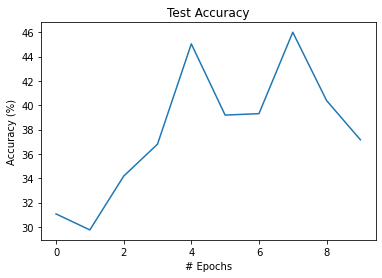

In [18]:
import matplotlib.pyplot as plt

plt.plot(accs)
plt.title("Test Accuracy")
plt.xlabel("# Epochs")
plt.ylabel("Accuracy (%)")
plt.show()